In [1]:
#
import numpy as np
import os, sys

sys.path.insert(0, '/global/homes/q/qmxp55/DESI/bgstargets/py')

from io_ import get_sweep_whole, getBGSbits, flux_to_mag
from io_ import get_random, get_isdesi, get_dict, bgsmask, get_reg, get_svfields, gaiaAEN
from cuts import getGeoCuts, bgsbut
from QA import getStats, flow, mollweide, mycmap, plot_sysdens, overdensity, hexbin

from QA import set_mwd, get_radec_mw
from io_ import get_isdes

import healpy as hp
import astropy.io.fits as fits
import fitsio
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
from astropy.coordinates import SkyCoord
import astropy.units as units
from astropy.table import Table

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

# AGNs

In [2]:
#
dr = 'dr9'
#survey = 'north' #is either south (DECaLS+DES) or north (BASS/MzLS)
version = '0.1.0'
filesdir = '/global/cscratch1/sd/qmxp55/bgstargets_output/'
Nranfiles = 3
reg = 'desi'
dec_resol_ns = 32.375
if (dr == 'dr9sv'): Nranfiles = 20 # because the randoms for dr9d have a density of 100000 = 5000*20

pathdir = os.path.abspath(os.getcwd())+'/%s-%s_%s_agns' %(dr, reg, version)
ispathdir = os.path.isdir(pathdir)
if not ispathdir: os.mkdir(pathdir)

# for healpy
dr8pix     = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits'
dr9pix = '/global/cfs/cdirs/desi/target/catalogs/dr9m/0.44.0/pixweight/main/resolve/bright/pixweight-bright.fits'

if dr[:3] == 'dr8': pixfile = dr8pix
elif dr[:3] == 'dr9': pixfile = dr9pix
    
hdr          = fits.getheader(pixfile,1)
nside,nest   = hdr['hpxnside'],hdr['hpxnest']
npix         = hp.nside2npix(nside)
pixarea      = hp.nside2pixarea(nside,degrees=True)

In [3]:
#load catalogues
if dr == 'dr9sv': N = 1
else: N = Nranfiles

#CATALOGUE
cat = np.load(filesdir+dr+'/'+version+'/'+'bgstargets'+'.npy', mmap_mode='r+')
catinreg = (cat[reg]) & (cat['desi'])
cat = cat[catinreg]
print('CATALOGUE DONE...')

#RANDOMS
ran = np.load(filesdir+dr+'/'+dr+'_random_N'+str(N)+'.npy', mmap_mode='r+')
ran_ex = np.load(filesdir+dr+'/'+'extra_random_N'+str(N)+'_n256.npy', mmap_mode='r+')
raninreg = (ran_ex[reg]) & (ran_ex['desi'])
ran = ran[raninreg]
ran_ex = ran_ex[raninreg]
print('RANDOMS DONE...')


CATALOGUE DONE...
RANDOMS DONE...


In [4]:
catinreg = np.ones(len(cat), dtype=bool)
raninreg = np.ones(len(ran), dtype=bool)

In [5]:
#bgsmask = bgsmask()
rancuts = getGeoCuts(ran, randoms=True)

In [6]:
#Notes: This hpdict is used to get the area only using the randoms. 
#This use the randoms within the DESI footprint and without any masking (maskrand=None) as we want the area without wholes.
hpdict0 = get_dict(cat=None, pixmapfile=pixfile, hppix_ran=ran_ex['hppix'], hppix_cat=None, 
                      maskrand=None, maskcat=None, Nranfiles=Nranfiles, ranindesi=ran_ex['desi'], catindesi=None, 
                            desifootprint=True, namesels=None, target_outputs=False, log=True)

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  213988655
bgsfracarea DONE...
regions DONE...
area_all = 14266 deg2
bgsarea_south = 9717 deg2
bgsarea_decals = 8603 deg2
bgsarea_des = 1113 deg2
bgsarea_north = 4549 deg2
bgsarea_south_n = 5324 deg2
bgsarea_south_s = 4393 deg2
bgsarea_svfields = 697 deg2
bgsarea_svfields_n = 201 deg2
bgsarea_svfields_s = 496 deg2
areas DONE...


In [7]:
#
bgsbut_fracs_but_lg = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['QC_FM', 'QC_FI', 'QC_FF', 'LG'], bgsmask=bgsmask(), rlimit=21)

bgs = {}

schlegel_color = (cat['ZMAG'] - cat['W1MAG']) - 3/2.5 * (cat['GMAG'] - cat['RMAG']) + 1.2
rfibcol =(cat['RFIBERMAG'] < 20.75) | ((cat['RFIBERMAG'] < 21.5) & (schlegel_color > 0.))

# Main selection
bgs['nominal main'] = (bgsbut_fracs_but_lg) & (cat['RMAG'] < 19.5)
bgs['nominal lower'] = (bgsbut_fracs_but_lg) & (cat['RMAG'] > 19.5) & (cat['RMAG'] < 20.0)
bgs['nominal'] = (bgsbut_fracs_but_lg) & (cat['RMAG'] < 20.0)

# rfibcol selection
bgs['proposal1 main'] = ((bgsbut_fracs_but_lg) & (cat['RMAG'] < 19.5)) | ((bgsbut_fracs_but_lg) & (rfibcol) & (cat['RMAG'] > 19.5) & (cat['RMAG'] < 20.3))
bgs['proposal1 lower'] = ((bgsbut_fracs_but_lg) & (~rfibcol) & (cat['RMAG'] > 19.5) & (cat['RMAG'] < 20.0)) | ((bgsbut_fracs_but_lg) & (rfibcol) & (cat['RMAG'] > 20.3) & (cat['RMAG'] < 20.5))
bgs['proposal1'] = (bgs['proposal1 main']) | (bgs['proposal1 lower'])

# rfibcol relaxed selection
bgs['proposal2 main'] = ((bgsbut_fracs_but_lg) & (cat['RMAG'] < 19.5))
bgs['proposal2 lower'] = ((bgsbut_fracs_but_lg) & (rfibcol) & (cat['RMAG'] > 19.5) & (cat['RMAG'] < 20.3))
bgs['proposal2'] = (bgs['proposal2 main']) | (bgs['proposal2 lower'])

## AGNs in BGS selection

### agn w2:

    * (z-W2)-(g-r) > -0.5        #W2 AGNs colour selection
    * W2 SNR > 10                #W2 signak to noise ratio > 10
    * MASKBITS &2**(9)           #W2 WISEMASK
    * flux_W2 > 0                #extinceted corrected W2 flux above 0
    * ~(star)                    #not a STAR
    * ~(bgs)                     #not a BGS

### quality:

    * flux_{g,r,z} > 0        #extinceted corrected flux above 0 for g,r and z
    * flux_ivar_{g,r,z} > 0   #no flux error for g,r and z
    * nobs_{g,r,z} > 1        #at least 1 observation in g,r and z bands
    * fibertotmag_r > 15      #extincted corrected r-band fiber total magnitude
    * G == 0 | G > 15)       #not in Gaia or in Gaia with G-mag > 15
    * TYPE != DUP
    * MASKBITS & 2**(1)       # masking around Bright Stars
    * MASKBITS & 2**(13)      # masking around Globular Clusters
    
### additional:

    * W1-W2 > -0.2            #
    * (z-W1)-(g-r) > -0.7     #
    * W1 SNR > 10             #
    
### star:

    * (G != 0 & G-r < 0.6) | (G == 0 & TYPE == PSF)
    * ~(agn W2)


In [8]:
#

fluxr = (cat["FLUX_R"]/cat["MW_TRANSMISSION_R"]) > 0
fluxg = (cat["FLUX_G"]/cat["MW_TRANSMISSION_G"]) > 0
fluxz = (cat["FLUX_Z"]/cat["MW_TRANSMISSION_Z"]) > 0
fluxw1 = (cat["FLUX_W1"]/cat["MW_TRANSMISSION_W1"]) > 0
fluxw2 = (cat["FLUX_W2"]/cat["MW_TRANSMISSION_W2"]) > 0
error = (cat["FLUX_IVAR_G"]>0) & (cat["FLUX_IVAR_R"]>0) & (cat["FLUX_IVAR_Z"]>0)
Grr = cat['G'] - 22.5 + 2.5*np.log10(cat['FLUX_R'])
fibertot_r = cat["FIBERTOTFLUX_R"]/cat["MW_TRANSMISSION_R"]
fibertomag_r = flux_to_mag(fibertot_r)
w1sn = cat['FLUX_W1'] * np.sqrt(cat['FLUX_IVAR_W1'])
w2sn = cat['FLUX_W2'] * np.sqrt(cat['FLUX_IVAR_W2'])
psftype = cat['TYPE']
psflike = ((psftype == 'PSF') | (psftype == b'PSF') | (psftype == 'PSF ') | (psftype == b'PSF '))

#

agnw2 = (cat['ZMAG'] - cat['W2MAG'] - (cat['GMAG'] - cat['RMAG']) > -0.5) &\
        (w2sn > 10) &\
        ((cat["MASKBITS"]&2**(9))==0) &\
        (fluxw2)
        

quality = (fluxr) & (fluxg) & (fluxz) &\
          (error) &\
          ((cat['BGSBITS']& 2**(bgsmask()['nobs']))!=0) &\
          (fibertomag_r > 15) &\
            ((cat['G'] == 0) | (cat['G'] > 15)) &\
            (cat["TYPE"]!='DUP') &\
            ((cat['BGSBITS']&2**(bgsmask()['BS']))!=0) &\
            ((cat['BGSBITS']&2**(bgsmask()['GC']))!=0) &\
            (cat['RMAG'] < 20.3) &\
            (cat['RFIBERMAG'] < 22)
        
stars = ((cat['G'] != 0) & (Grr < 0.6)) | ((cat['G'] == 0) & (psflike))

additional = ((cat['W1MAG'] - cat['W2MAG']) > -0.2) &\
              (cat['ZMAG'] - cat['W1MAG'] - (cat['GMAG'] - cat['RMAG']) > -0.7) &\
              (w1sn > 10)

agn_ext = (agnw2) & (additional)


In [9]:
#
agns = {}

agns['agn'] = (agnw2) & (quality) & ~((stars) & (~agnw2))
agns['agn+extra'] = (agn_ext) & (quality) & ~((stars) & (~agn_ext))


In [10]:
#
main = {}

for key in ['nominal', 'proposal1', 'proposal2']:
    
    main['agn ~%s' %(key)] = (agnw2) & (quality) & ~((stars) & (~agnw2)) & (~bgs[key])
    main['agn+extra ~%s' %(key)] = (agn_ext) & (quality) & ~((stars) & (~agn_ext)) & (~bgs[key])


In [11]:
#overlaps BGS scenarios with AGNs
A = hpdict0['%s_%s' %('area', 'all')]
for key, val in main.items():
    print(key, np.round(np.sum(val)/A, 1))

agn ~nominal 65.2
agn+extra ~nominal 58.0
agn ~proposal1 50.6
agn+extra ~proposal1 46.9
agn ~proposal2 53.5
agn+extra ~proposal2 48.6


In [12]:
#dic with default BGS selection and in DESI footprint
hpdict = get_dict(cat=cat, pixmapfile=pixfile, hppix_ran=ran_ex['hppix'], hppix_cat=cat['hppix'], 
                      maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['nobs'])), maskcat=None, 
                          Nranfiles=Nranfiles, ranindesi=ran_ex['desi'], catindesi=cat['desi'], desifootprint=True, 
                              namesels=main, galb=cat['b'], log=True, survey='custom')

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  213988655
bgsfracarea DONE...
regions DONE...
area_all = 14082 deg2
bgsarea_south = 9589 deg2
bgsarea_decals = 8484 deg2
bgsarea_des = 1105 deg2
bgsarea_north = 4493 deg2
bgsarea_south_n = 5263 deg2
bgsarea_south_s = 4326 deg2
bgsarea_svfields = 690 deg2
bgsarea_svfields_n = 199 deg2
bgsarea_svfields_s = 491 deg2
areas DONE...
computing for  north / agn ~nominal
computing for  north / agn+extra ~nominal
computing for  north / agn ~proposal1
computing for  north / agn+extra ~proposal1
computing for  north / agn ~proposal2
computing for  north / agn+extra ~proposal2
target densities in north DONE...
computing for  south / agn ~nominal
computing for  south / agn+extra ~nominal
computing for  south / agn ~proposal1
computing for  south / agn+extra ~proposal1
computing for  south / agn ~proposal2
computing for  south / agn+extra ~proposal2
target densities in south DONE...
meandens_agn ~nominal_all = 

In [13]:
if reg == 'desi':
    survey = 'all'
    bgsarea = 'area'
else:
    survey = reg
    bgsarea = 'bgsarea'

In [14]:
main.keys()

dict_keys(['agn ~nominal', 'agn+extra ~nominal', 'agn ~proposal1', 'agn+extra ~proposal1', 'agn ~proposal2', 'agn+extra ~proposal2'])

In [15]:
#
import pandas as pd

def densities(cat, main, hpdict, keys):
    
    densities = {'BGS':[], 'BASS/MzLS':[], 'DECaLS':[]}
    N = 1
    for key in keys:

        val = main[key]

        densities['BGS'].append(key)
        densities['BASS/MzLS'].append(np.round(np.sum((val) & (cat['north']))/hpdict['%s_%s' %('bgsarea', 'north')], N))
        densities['DECaLS'].append(np.round(np.sum((val) & (cat['south']))/hpdict['%s_%s' %('bgsarea', 'south')], N))
        #densities['DECaLS SGC'].append(np.round(np.sum((val) & (cat['south']) & (cat['b'] < 0))/hpdict['%s_%s' %('bgsarea', 'south_s')], N))
        #densities['DESI'].append(np.round(np.sum(val)/hpdict['%s_%s' %(bgsarea, survey)], 0))

    densities['BGS'].append('AREA')
    densities['BASS/MzLS'].append(np.round(hpdict['%s_%s' %('bgsarea', 'north')], N))
    densities['DECaLS'].append(np.round(hpdict['%s_%s' %('bgsarea', 'south')], N))
    #densities['DECaLS SGC'].append(np.round(hpdict['%s_%s' %('bgsarea', 'south_s')], N))

    tab = pd.DataFrame.from_dict(densities)
    
    return tab

In [16]:
#
keys = list(main.keys())
tab = densities(cat, main, hpdict, keys)
tab

BGS  BASS/MzLS  DECaLS
0          agn ~nominal       64.0    67.0
1    agn+extra ~nominal       57.6    59.3
2        agn ~proposal1       50.8    51.5
3  agn+extra ~proposal1       47.4    47.6
4        agn ~proposal2       52.8    54.9
5  agn+extra ~proposal2       48.7    49.6
6                  AREA     4493.1  9588.6

In [17]:
#overlap between BGS scenarios and AGNs
overlap = {}
for key, val in agns.items():
    for key2, val2 in bgs.items():
        overlap['%s %s' %(key, key2)] = (val) & (val2)

In [18]:
#
keys = keys = [i for i in list(overlap.keys()) if i[:4]!='agn+']
tab = densities(cat, overlap, hpdict, keys)
tab

BGS  BASS/MzLS  DECaLS
0     agn nominal main       17.1    22.1
1    agn nominal lower       17.2    22.7
2          agn nominal       34.4    44.8
3   agn proposal1 main       45.6    56.9
4  agn proposal1 lower        2.0     3.4
5        agn proposal1       47.6    60.3
6   agn proposal2 main       17.1    22.1
7  agn proposal2 lower       28.4    34.8
8        agn proposal2       45.6    56.9
9                 AREA     4493.1  9588.6

In [19]:
#
keys = keys = [i for i in list(overlap.keys()) if i[:4]=='agn+']
tab = densities(cat, overlap, hpdict, keys)
tab

BGS  BASS/MzLS  DECaLS
0     agn+extra nominal main       14.3    18.1
1    agn+extra nominal lower       13.8    17.5
2          agn+extra nominal       28.1    35.6
3   agn+extra proposal1 main       37.0    45.4
4  agn+extra proposal1 lower        1.2     2.0
5        agn+extra proposal1       38.2    47.4
6   agn+extra proposal2 main       14.3    18.1
7  agn+extra proposal2 lower       22.8    27.3
8        agn+extra proposal2       37.0    45.4
9                       AREA     4493.1  9588.6

In [46]:
def n_density(rmag, A):
    '''
    Get the cumulative number density
    '''
    
    eta = []
    mag = np.linspace(14, 20.5, 40)
    
    for i in range(len(mag)):
        
        N = np.sum(rmag < mag[i])
        #eta.append([mag[i], etaR*(N/Nran)])
        eta.append([mag[i], N/A])
            
    eta = np.array(eta).transpose()
    #print('DONE...')
    
    return eta

In [50]:
#
#['agn ~nominal', 'agn+extra ~nominal', 'agn ~proposal1', 
#'agn+extra ~proposal1', 'agn ~proposal2', 'agn+extra ~proposal2']
etas = {}
rmag = cat['RMAG']
#for regi in ['south_n', 'south_s', 'north', 'desi']:
for regi in ['south', 'north']:
    
    regi_ = cat[regi]
    
    if regi != 'desi':
        A = hpdict['bgsarea_%s' %(regi)]
    else:
        A = hpdict['area_all']
        

    for key, val in main.items():
        mask = (val) & (regi_)
        
        etas['%s_%s' %(regi, key)] = n_density(rmag=rmag[mask], A=A)
        print('%s %s --> A=%.2f --> Dens=%.2f' %(regi, key, A, np.sum(mask)/A))
        

south agn ~nominal --> A=9588.60 --> Dens=67.02
south agn+extra ~nominal --> A=9588.60 --> Dens=59.34
south agn ~proposal1 --> A=9588.60 --> Dens=51.47
south agn+extra ~proposal1 --> A=9588.60 --> Dens=47.56
south agn ~proposal2 --> A=9588.60 --> Dens=54.92
south agn+extra ~proposal2 --> A=9588.60 --> Dens=49.56
north agn ~nominal --> A=4493.09 --> Dens=64.03
north agn+extra ~nominal --> A=4493.09 --> Dens=57.58
north agn ~proposal1 --> A=4493.09 --> Dens=50.82
north agn+extra ~proposal1 --> A=4493.09 --> Dens=47.43
north agn ~proposal2 --> A=4493.09 --> Dens=52.82
north agn+extra ~proposal2 --> A=4493.09 --> Dens=48.66


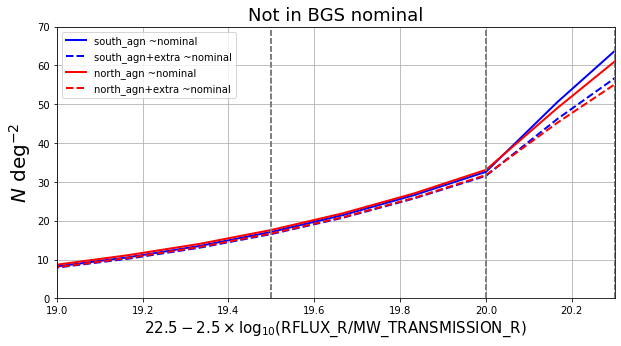

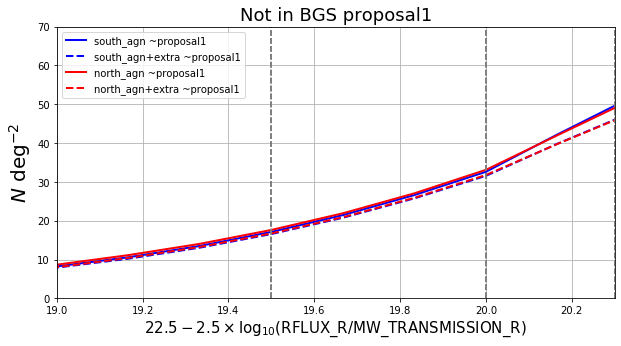

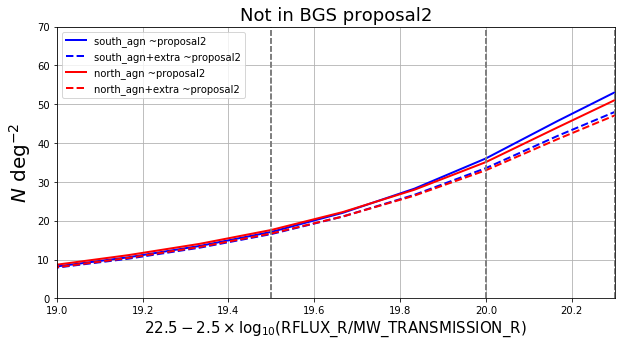

In [69]:
#
for col in ['nominal', 'proposal1', 'proposal2']:
    
    plt.figure(figsize=(10, 5))

    for key, item in etas.items():

        if key.split('~')[1] == col:

            plt.title('Not in BGS %s' %(key.split('~')[1]), size=18)
            plt.plot(item[0], item[1], lw=2, ls= '-' if key.split(' ')[0].split('_')[1] != 'agn+extra' else '--', color='b' if key[:1] == 's' else 'r', label='%s' %(key))
            for i in [19.5, 20, 20.3]:
                plt.axvline(i, ls='--', color='gray')
                
    plt.xlabel(r'$22.5 - 2.5\times \log_{10}$(%s/%s)' %('RFLUX_R', 'MW_TRANSMISSION_R'), fontsize=15)
    plt.ylabel(r'$N$ deg$^{-2}$', fontsize=20)
    plt.xlim(19,20.3)
    plt.ylim(0, 70)     
    plt.legend()
    plt.grid()
        

In [70]:
from QA import mollweide, mycmap, plot_sysdens
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib

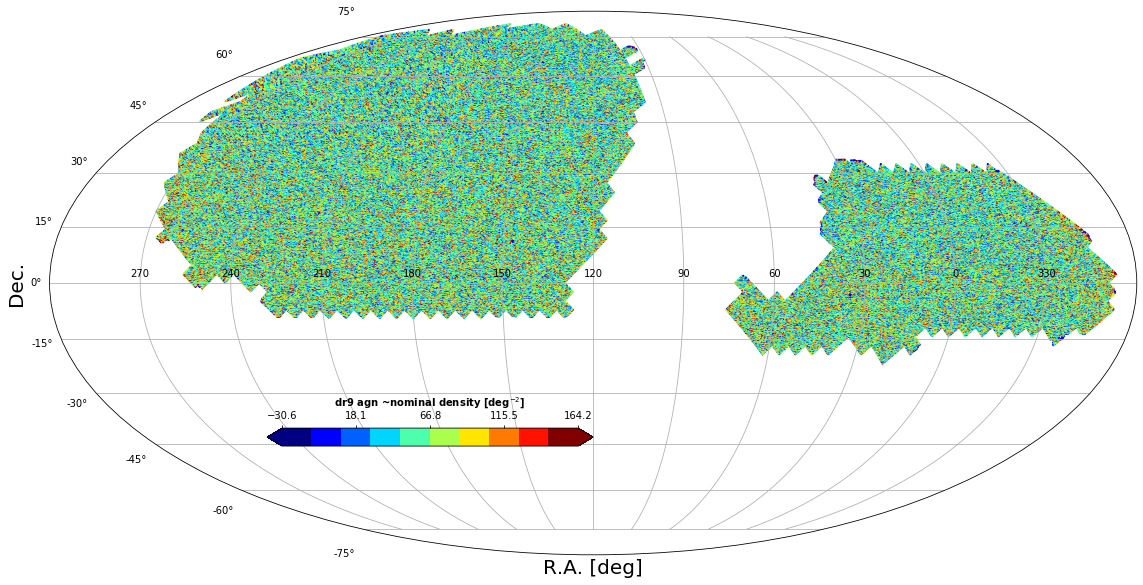

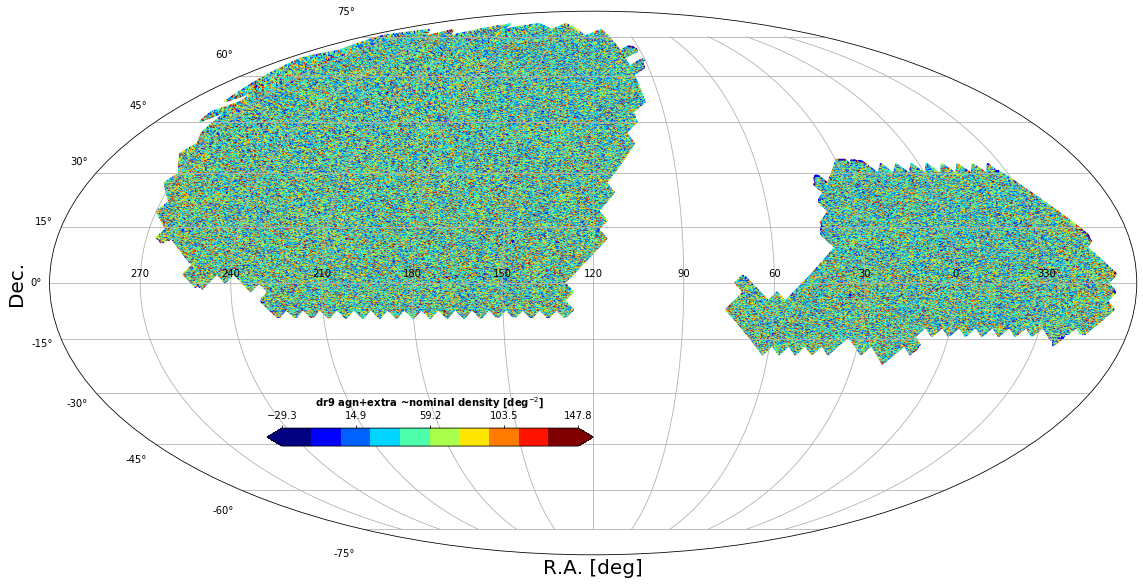

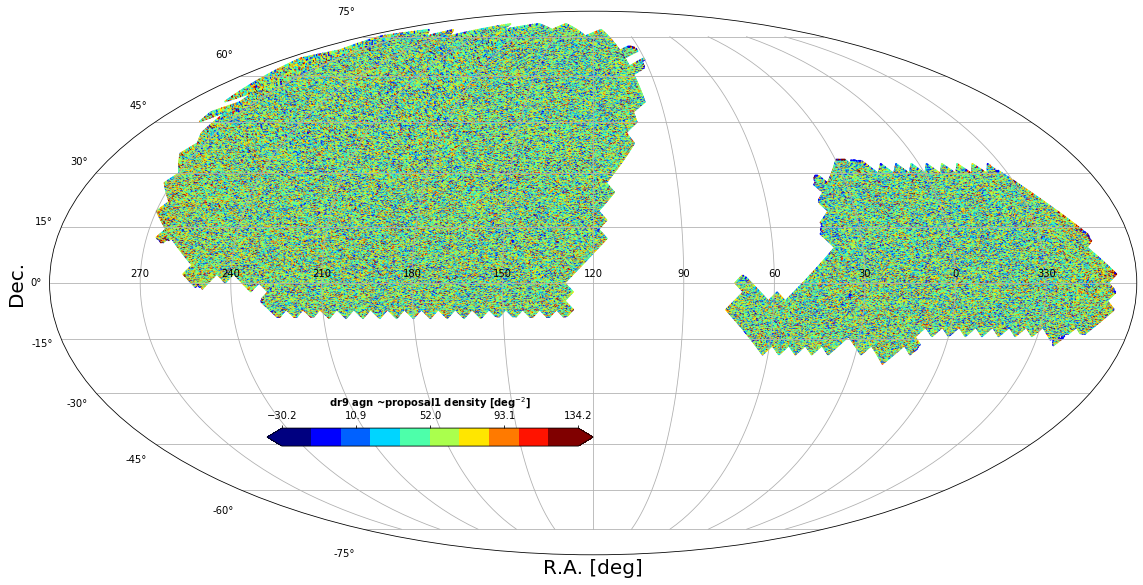

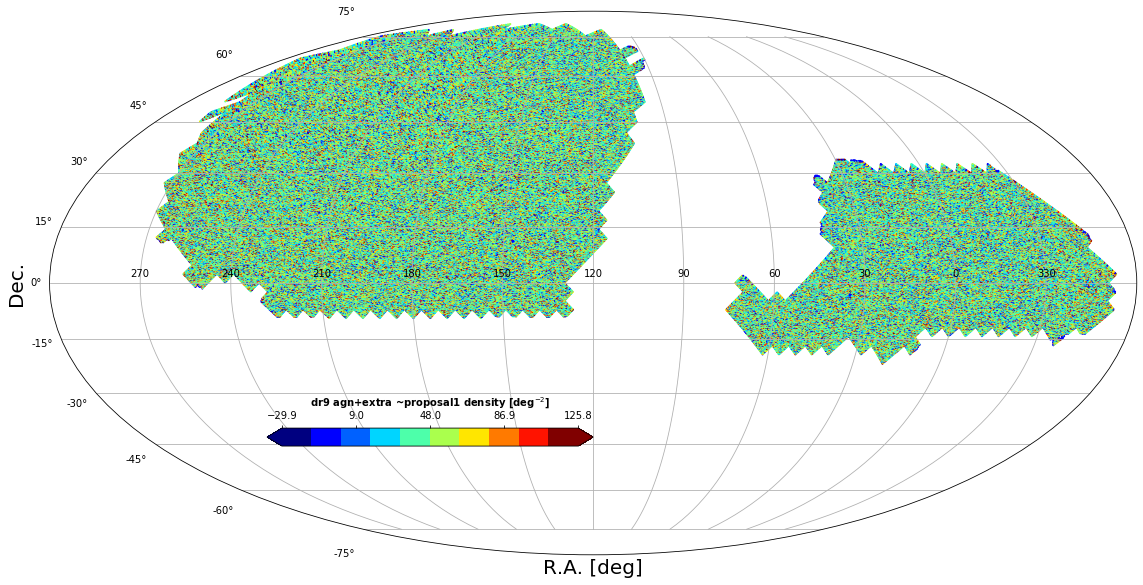

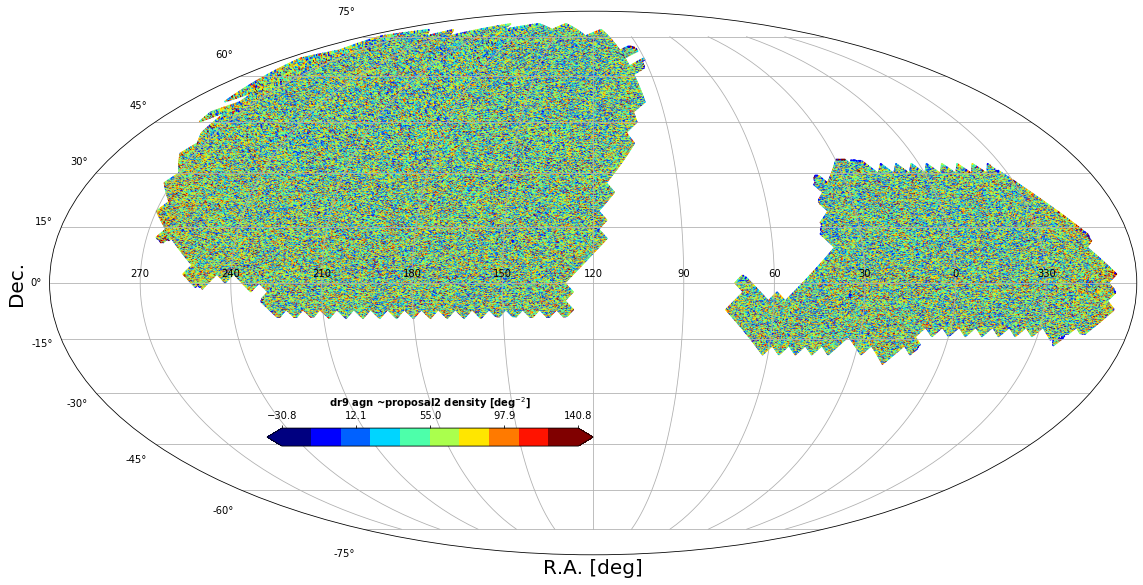

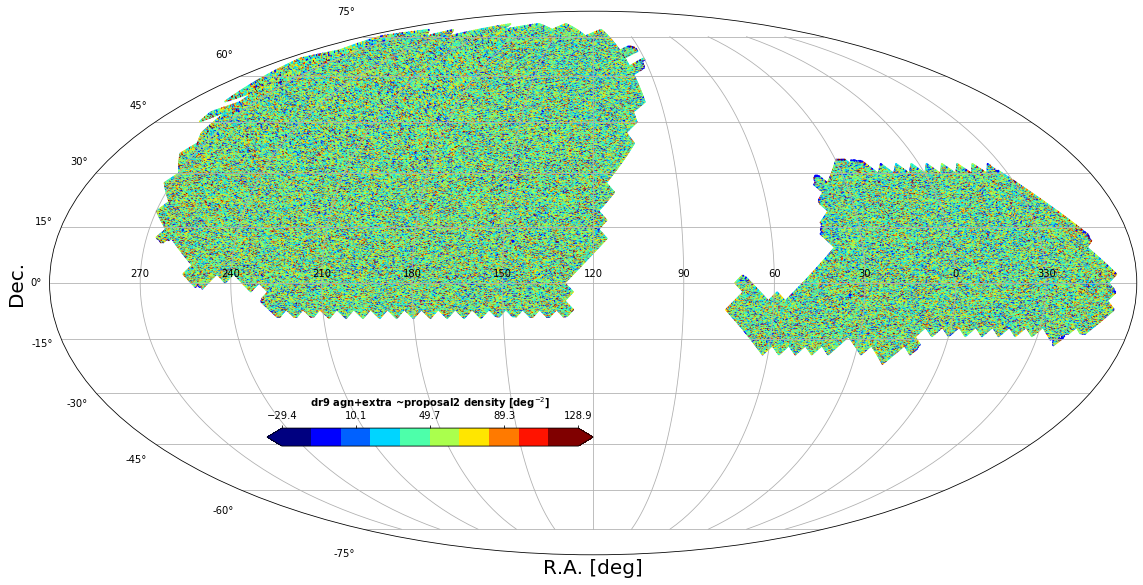

In [72]:
#

for key, val in main.items():
    
    fig = plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(1, 1)

    org          = 120  # centre ra for mollweide plots
    projection   = 'mollweide'
    cm = mycmap(matplotlib.cm.jet, 10,0,1)
    cmr= mycmap(matplotlib.cm.jet_r,10,0,1)

    mollweide(hpdict=hpdict, namesel=key, reg=survey, projection=projection, n=0, org=org, cm=cm, fig=fig, gs=gs, cval=None, perc=(0.3,99.7), dr=dr, cname=None)

    file = '%s/skydens_%s_%s' %(pathdir, dr, key)
    fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)
    

In [30]:
#
from io_ import match_coord
def match_external(cat=None, ext=None):
    
    #if maskcat is None: maskcat = np.ones_like(cat, dtype=bool)
    # matching LS with gama stars and galaxies
    idx20, idx10, d2d0, d_ra0, d_dec0 = match_coord(cat['RA'], cat['DEC'], 
                                                                ext['RA'], ext['DEC'], search_radius=0.5)

    # LS DR8 matched with gama
    cat_ext = np.zeros_like(cat['RA'], dtype='?') #LS that match with gama

    cat_ext[idx20.tolist()] = True
    
    return cat_ext

## Main Selection

In [20]:
dark_main = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/desitarget/dr9_0.49.0_targets_main_resolve_dark.npy')

In [21]:
#
extra = Table()

extra['RA'] = dark_main['RA']
extra['DEC'] = dark_main['DEC']
extra['DESI_TARGET'] = dark_main['DESI_TARGET']

#angle to healpy pixels array
extra['hppix'] = hp.ang2pix(nside,(90.-dark_main['DEC'])*np.pi/180.,dark_main['RA']*np.pi/180.,nest=True)

#
extra['desi'] = get_reg(reg='desi', hppix=extra['hppix'])
extra['north'] = get_reg(reg='north', hppix=extra['hppix'])
extra['south'] = get_reg(reg='south', hppix=extra['hppix'])


In [22]:
dark_main = extra[extra['desi']]

In [23]:
del extra, ran

In [25]:
del ran_ex

In [28]:
#DESI target classes
bits = {'ELG':2**(1), 'QSO':2**(2), 'LRG':2**(0)}
targ_list = {}
for key, val in bits.items():
    targ_list[key] = (dark_main["DESI_TARGET"] & val) != 0
    for i in ['south', 'north']:
        print(key+' '+i, np.sum((targ_list[key]) & (dark_main[i])))


ELG south 23350843
ELG north 11501467
QSO south 2751458
QSO north 1335593
LRG south 5841262
LRG north 2715828


In [47]:
#
mask = cat['south']
mask2 = targ_list['LRG']
lrg = match_external(cat={'RA':cat['RA'], 'DEC':cat['DEC']}, ext={'RA':dark_main['RA'][mask2], 'DEC':dark_main['DEC'][mask2]})

Doubly matched objects = 20
Final matched objects = 2450848


In [31]:
#
matches = {}

for key in targ_list.keys():
    
    mask = targ_list[key]
    %time matches[key] = match_external(cat={'RA':cat['RA'], 'DEC':cat['DEC']}, ext={'RA':dark_main['RA'][mask], 'DEC':dark_main['DEC'][mask]})
    print(key, 'DONE...')
    

Doubly matched objects = 12
Final matched objects = 123070
CPU times: user 1min 14s, sys: 14.5 s, total: 1min 28s
Wall time: 1min 20s
ELG DONE...
Doubly matched objects = 19
Final matched objects = 775783
CPU times: user 28.5 s, sys: 6.88 s, total: 35.3 s
Wall time: 31.5 s
QSO DONE...
Doubly matched objects = 20
Final matched objects = 2450848
CPU times: user 45.8 s, sys: 7.71 s, total: 53.5 s
Wall time: 48.6 s
LRG DONE...


In [46]:
#
overlap = {}
for key, val in main.items():
    for key2, val2 in matches.items():
        
        overlap['%s & %s' %(key, key2)] = (val) & (~val2)


In [45]:
#
keys = ['%s & %s' %((i), 'ELG') for i in list(main.keys())]
tab_den = densities(cat, overlap, hpdict, keys)
tab_den

BGS  BASS/MzLS  DECaLS
0          agn ~nominal & ELG        2.9     3.7
1    agn+extra ~nominal & ELG        2.7     3.5
2        agn ~proposal1 & ELG        2.6     3.2
3  agn+extra ~proposal1 & ELG        2.5     3.1
4        agn ~proposal2 & ELG        2.6     3.2
5  agn+extra ~proposal2 & ELG        2.5     3.1
6                        AREA     4493.1  9588.6

In [40]:
#
keys = ['%s & %s' %((i), 'LRG') for i in list(main.keys())]
tab_den = densities(cat, overlap, hpdict, keys)
tab_den

BGS  BASS/MzLS  DECaLS
0          agn ~nominal & LRG        0.9     1.0
1    agn+extra ~nominal & LRG        0.6     0.6
2        agn ~proposal1 & LRG        0.5     0.6
3  agn+extra ~proposal1 & LRG        0.3     0.3
4        agn ~proposal2 & LRG        0.6     0.8
5  agn+extra ~proposal2 & LRG        0.4     0.5
6                        AREA     4493.1  9588.6

In [47]:
#
keys = ['%s & %s' %((i), 'QSO') for i in list(main.keys())]
tab_den = densities(cat, overlap, hpdict, keys)
tab_den

BGS  BASS/MzLS  DECaLS
0          agn ~nominal & QSO       22.9    26.1
1    agn+extra ~nominal & QSO       16.8    18.8
2        agn ~proposal1 & QSO        9.9    10.8
3  agn+extra ~proposal1 & QSO        6.9     7.2
4        agn ~proposal2 & QSO       11.9    14.3
5  agn+extra ~proposal2 & QSO        8.1     9.2
6                        AREA     4493.1  9588.6

In [49]:
matches.keys()

dict_keys(['ELG', 'QSO', 'LRG'])

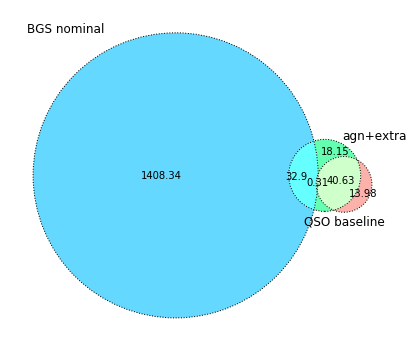

In [50]:
from QA import plot_venn3

A = hpdict['area_all']
plot_venn3(A=(bgs['nominal']), B=(agns['agn+extra']), C=(matches['QSO']), norm=A, 
           labels=['BGS nominal', 'agn+extra', 'QSO baseline'], file=None, colors = ['deepskyblue', 'springgreen', 'salmon'])

In [ ]:
plt.hist()

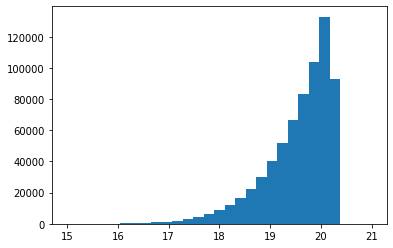

In [24]:
#
bins = np.linspace(15, 21, 30)
plt.hist(cat['RMAG'][main['QSO W1 & G>16']], bins=bins)
plt.show()

In [27]:
tot = len(cat['RMAG'][main['QSO W1 & G>16']])
samp1 = (main['QSO W1 & G>16']) & (cat['RMAG'] < 19.5)
samp2 = (main['QSO W1 & G>16']) & (cat['RMAG'] > 19.5) & (cat['RMAG'] < 20.3)
print(100*np.sum(samp1)/tot, 100*np.sum(samp2)/tot)

36.571454624875535 63.42839829921417


In [29]:
sam = 100*np.sum((main['QSO W1 & G>16']) & (cat['TYPE'] == 'PSF'))/tot

In [30]:
sam

92.47618473322636